## FDM-CBM-DATC Project(Final Version)

In [154]:
'''using packages'''
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [155]:
'''version: 111117R2'''
class MultiMachineCBMModel(object):
    def __init__(self, num_parts, num_machines, arr_times, proc_times, motor_speeds):
        # arr_times = np.array(num_parts + num_machines)
        # proc_times = np.array(num_parts + num_machines)
        self.num_machines = num_machines
        self.num_parts = num_parts
        self.arr_times = arr_times
        self.proc_times = proc_times
        self.comp_times = np.zeros(num_parts+num_machines)
        self.motor_speeds = motor_speeds
        self.prio = np.hstack((-1*np.ones(num_parts), 1*np.ones(num_machines)))
        self.clocks = np.ones(num_machines)*float("inf")*-1
        self.assign_jobs = -np.ones((num_machines, num_parts+1), dtype=np.int)
        self.loads = np.zeros(num_machines)
        self.simu_model()
    
    def simu_model(self):
        ''' step1: sort the parts sequence (avoid maintenance jobs)'''
        job_seq = np.argsort(self.arr_times)
        
        ''' step2: compute the completion time for each jobs'''
        for job_i in job_seq:
            
            ''' step 2.1: determine the machine which the job should be assigned to'''
            if self.prio[job_i] == 1:
                # maintenance task should be on a certain machine
                machine_j = job_i - num_parts
            else:
                #sort the clocks, get the machine that will finish its job earlier
                clock_seq = np.argsort(self.clocks)
                machine_j = clock_seq[0]
            
            last_job_k = np.sum(self.assign_jobs[machine_j, :] != -1)

            ''' step 2.2: once the assgined machine determined, the completion time can be determined'''
            if self.arr_times[job_i] > self.clocks[machine_j]:
                self.clocks[machine_j] = self.arr_times[job_i] + self.proc_times[job_i]
                self.comp_times[job_i] = self.clocks[machine_j]
                self.assign_jobs[machine_j, last_job_k] = job_i
            else:
                if self.prio[job_i] == 1:
                    # if the job is maintenance tasks
                    self.clocks[machine_j] = self.clocks[machine_j] + self.proc_times[job_i]
                    self.comp_times[job_i] = self.arr_times[job_i] + self.proc_times[job_i]
                    self.comp_times[self.assign_jobs[machine_j, last_job_k-1]] = self.clocks[machine_j]
                    l = np.array([self.proc_times[job]*self.motor_speeds[job]/60 
                                  if job != -1 else 0 for job in self.assign_jobs[machine_j, :]])
                    remain_l = (self.clocks[machine_j] - self.comp_times[job_i])*\
                    motor_speeds[self.assign_jobs[machine_j, last_job_k-1]]/60
                    self.loads[machine_j] = np.sum(l) - remain_l 
                    
                else:
                    # if the job is production tasks
                    self.clocks[machine_j] = self.clocks[machine_j] + self.proc_times[job_i]
                    self.comp_times[job_i] = self.clocks[machine_j]
                    self.assign_jobs[machine_j, last_job_k] = job_i
    
    def get_comp_times(self):
        return self.comp_times
    def get_machine_loads(self):
        return self.loads

In [156]:
class Components(object):
    def __init__(self, series, tm, RUL, due_date, arr_time, 
                 k = 0.02, alpha =10):  #preset data
        self.series = series            # component series
        self.tm = tm                    # maintenance time
        self.RUL = RUL                  # remaining useful life
        self.k = k                      # arrival time gain's factor
        self.z = 0                      # the due date deviation
        self.delta = 0                  # the RUL deviation
        self.maint_arr_time = arr_time  # the maintenance arrival time
        self.maint_comp_time = 0        # the maintenance completion time
        self.maint_due_date = due_date  # the due date of the maintenance action
        self.alpha = alpha              # the due date gain's factor
        
    def RULinput(self, sensor_input):                # the RUL input from sensor
        self.RUL = sensor_input
            
    def update_delta(self, load):                    # update RUL deviation
        self.delta = (self.RUL - load)/self.RUL
        
    def update_due_date(self):                       # update the maintenance due date
        self.maint_due_date = self.maint_due_date + self.alpha * self.delta
        
    def update_z(self):                              # update due date deviation
        self.z = self.maint_due_date - self.maint_comp_time
            
    def update_comp_time(self, comp_time):           # set completion time
        self.maint_comp_time = comp_time
            
    def update_arr_time(self):                       # update arrival time
        self.maint_arr_time = self.maint_arr_time + self.k * self.z
        

In [157]:
class Parts(object):
    def __init__(self, series, volume, e_rate ,min_e_rate, max_e_rate, due_date, arr_time, 
                 k = .01, alpha = .01):
        self.series = series               # name of the part
        self.volume = volume               # volume
        self.hat_e_rate = e_rate           # initial extrution rate
        self.min_e_rate = min_e_rate
        self.max_e_rate = max_e_rate
        self.hat_p = volume/e_rate         # initial production time
        self.hat_motor_speed = -9.1 + 0.187 * e_rate*60           # initial motor speed
        self.arr_time = arr_time           # the arrival time of the part
        self.comp_time = 0                 # the completion time
        self.d = due_date                  # part due date
        self.k = k                         # arrival time control step
        self.alpha = alpha                 # capacity control step 
        self.z = 0                         # due_date diviation
    def update_comp_time(self, comp_time):      #set completion time
        self.comp_time = comp_time
    
    def update_z(self):                         #set due date deviation
        self.z = self.d - self.comp_time
    
    def update_prod_time(self):                 #machine capacity control
        self.hat_p = self.volume/self.hat_e_rate

    def update_arr_time(self):                  #arrival time control
        self.arr_time += self.k*self.z
     
    def update_e_rate(self):
        self.hat_e_rate = self.hat_e_rate + self.hat_e_rate*self.alpha*self.z
        self.hat_e_rate = np.clip(self.hat_e_rate, self.min_e_rate, self.max_e_rate)
    
    def update_motor_speed(self):
        self.hat_motor_speed = -9.1 + 0.187 * self.hat_e_rate *60

__Experiment 1__
- Two print parts, One Machine(Maintenance) Case

In [158]:
#Step 1.1: Initialization: parts information
num_parts = 2                       # number of parts in the system
volume = np.array([36000, 54000])   # volume of parts unit: mm^3
min_e_rate = 4                      # min extrution rate unit: mm^3/sec
max_e_rate = 6                     # max extrution rate unit: mm^3/sec
init_e_rate = np.array([5, 5])      # initial extrution rate unit: mm^3/sec
due_date = np.array([18000, 34200]) # the due date of parts, unit: sec
arr_time = np.array([0,  3600])     # the arrival times, unit: sec

#Step 1.2: Ininitialization: maintenance information
num_components = 1
RUL = np.array([4000])              # the residual life, unit: rev
tm = np.array([1800])               # the maintenance time, unit: sec
maint_due_date = np.array([18000])  # set the maintance initial due dates, unit: sec
maint_arr_time = np.array([10000])  # set the maintance action time, unit: sec
iterations = 1500                   # algorithm running iteration
cl=0                                # running iteration index

#Step 2: Generate entities
parts = []
components = []
for i in range(num_parts):
    parts.append(Parts(i, volume[i], init_e_rate[i] ,min_e_rate, max_e_rate, due_date[i], arr_time[i]))
for j in range(num_components):
    components.append(Components(j, tm[j], RUL[j], maint_due_date[j], maint_arr_time[j]))
    
#Step 4: using preemptive simulation model to simulate the model
while cl<=iterations:
    # arrival time array
    parts_arr = np.array([p.arr_time for p in parts])
    maint_arr = np.array([c.maint_arr_time for c in components])
    total_arr = np.hstack((parts_arr, maint_arr))
    # process time array
    parts_pt = np.array([p.hat_p for p in parts])
    maint_pt = np.array([c.tm for c in components])
    total_pt = np.hstack((parts_pt, maint_pt))
    # motor speed array
    parts_ms = np.array([p.hat_motor_speed for p in parts])
    maint_ms = np.array([0 for c in components])
    total_ms = np.hstack((parts_ms, maint_ms))
    
    # do preemptive queue simulation
    model = MultiMachineCBMModel(num_parts, num_components, total_arr, total_pt, total_ms)
    total_ct = model.get_comp_times()
    parts_ct = total_ct[0:num_parts]
    maint_ct = total_ct[-num_components:]
    maint_load = model.get_machine_loads()
    
    # update parts information
    for i in range(num_parts):
        parts[i].update_comp_time(parts_ct[i])
        parts[i].update_z()
        parts[i].update_e_rate()
        parts[i].update_motor_speed()
        parts[i].update_prod_time()
        parts[i].update_arr_time()
    
    # update components information
    for j in range(num_components):
        components[j].update_comp_time(maint_ct[j])
        components[j].update_delta(maint_load[j])
        components[j].update_due_date()
        components[j].update_z()
        components[j].update_arr_time()
        
    #save datas
    if cl == 0:
        save_arr = total_arr
        save_cmp = total_ct
        save_due_date = np.hstack(([p.d for p in parts],[c.maint_due_date for c in components]))
        save_p = total_pt
    else:
        save_arr = np.vstack((save_arr, total_arr))
        save_cmp = np.vstack((save_cmp, total_ct))
        save_due_date = np.vstack((save_due_date, 
                                   np.hstack(([p.d for p in parts],[c.maint_due_date for c in components]))))
        save_p = np.vstack((save_p, total_pt))
    cl += 1
print(save_arr[-1])
print(save_cmp[-1])
print(save_due_date[-1])
print(save_p[-1])
print(maint_load)
#job_sequence_plot(parts, machine)

[ 10199.99872018  25199.9928759   13962.67166916]
[ 17999.99872018  34199.9928759   15762.67166916]
[ 18000.          34200.          15752.94466961]
[ 6000.  9000.  1800.]
[ 4069.42714337]


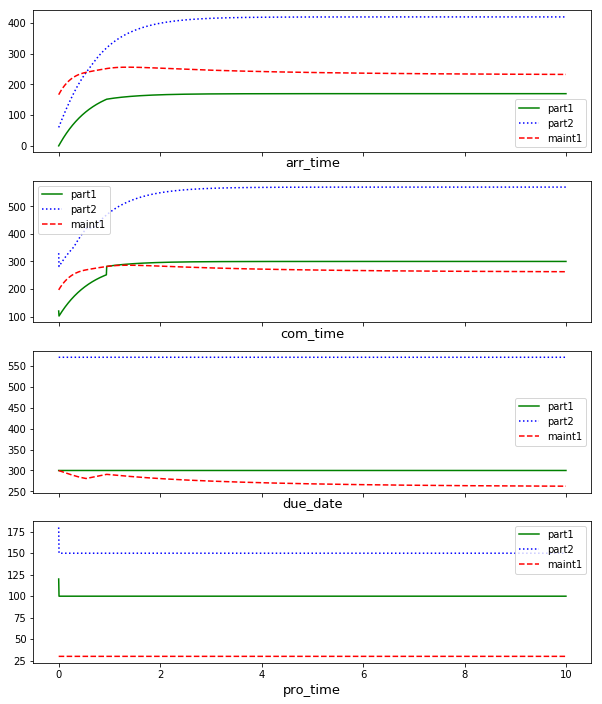

In [159]:
fig, ax = plt.subplots(4, figsize=(10, 12),sharex=True)
x = np.linspace(0,10,iterations+1)
char = ['g','b:','r--', 'c--']
l = ['part1','part2','maint1']
for i in range(num_parts+num_components): ax[0].plot(x, save_arr[:,i]/60, char[i])
for i in range(num_parts+num_components): ax[1].plot(x, save_cmp[:,i]/60, char[i])
for i in range(num_parts+num_components): ax[2].plot(x, save_due_date[:,i]/60, char[i])
for i in range(num_parts+num_components): ax[3].plot(x, save_p[:,i]/60, char[i])
ax[0].legend(l)
ax[1].legend(l)
ax[2].legend(l)
ax[3].legend(l)
ax[0].set_xlabel('arr_time', fontsize = 13)
ax[1].set_xlabel('com_time', fontsize = 13)
ax[2].set_xlabel('due_date', fontsize = 13)
ax[3].set_xlabel('pro_time', fontsize = 13)


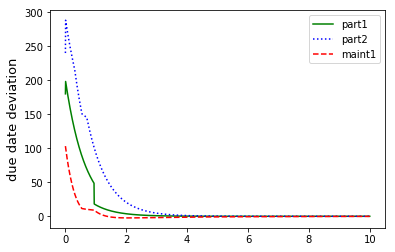

In [160]:
x = np.linspace(0,10,iterations+1)
char = ['g','b:','r--', 'c--']
l = ['part1','part2','maint1']
for i in range(num_parts+num_components): 
    plt.plot(x, (save_due_date[:,i]-save_cmp[:,i])/60, char[i])
plt.legend(l)
plt.ylabel('due date deviation', fontsize = 13)

__Experiment 2__
- Six print parts, One Machine(Maintenance) Case

In [161]:
#Step 1.1: Initialization: parts information
num_parts = 6                             # number of parts in the system
volume = np.array([26875, 26216, 29169,
                  30152, 21303, 25072])   # volume of parts unit: mm^3
min_e_rate = 4                            # min extrution rate unit: mm^3/sec
max_e_rate = 6                           # max extrution rate unit: mm^3/sec
#min_e_rate = 5                            # min extrution rate unit: mm^3/sec
#max_e_rate = 5                           # max extrution rate unit: mm^3/sec
min_temp = 180                            # min temperature unit: degree C
max_temp = 230                            # max temperature unit: degree C
init_e_rate = np.array([5, 5, 5, 
                        5, 5, 5])         # initial extrution rate unit: mm^3/sec
due_date = np.array([50000, 51000, 52000, 
                       25000, 24000, 13000]) # the due date of parts, unit: sec
arr_time = np.array([0, 0, 0, 
                     0, 0, 0])            # the arrival times, unit: sec

#Step 1.2: Ininitialization: maintenance information
num_components = 1
RUL = np.array([17000])
tm = np.array([1800])               # the maintenance time, unit: sec
maint_due_date = np.array([46800])  # set the maintance initial due dates, unit: sec
maint_arr_time = np.array([54000])  # set the maintance action time, unit: sec
iterations = 1500                   # algorithm running iteration
cl=0                                # running iteration index

#Step 2: Generate entities
parts = []
components = []
for i in range(num_parts):
    parts.append(Parts(i, volume[i], init_e_rate[i] ,min_e_rate, max_e_rate, due_date[i], arr_time[i]))
for j in range(num_components):
    components.append(Components(j, tm[j], RUL[j], maint_due_date[j], maint_arr_time[j]))
    #print(components[j].maint_due_date)
    
#Step 4: using preemptive simulation model to simulate the model
while cl<=iterations:
    # arrival time array
    parts_arr = np.array([p.arr_time for p in parts])
    maint_arr = np.array([c.maint_arr_time for c in components])
    total_arr = np.hstack((parts_arr, maint_arr))
    # process time array
    parts_pt = np.array([p.hat_p for p in parts])
    maint_pt = np.array([c.tm for c in components])
    total_pt = np.hstack((parts_pt, maint_pt))
    # motor speed array
    parts_ms = np.array([p.hat_motor_speed for p in parts])
    maint_ms = np.array([0 for c in components])
    total_ms = np.hstack((parts_ms, maint_ms))
    
    # do preemptive queue simulation
    model = MultiMachineCBMModel(num_parts, num_components, total_arr, total_pt, total_ms)
    total_ct = model.get_comp_times()
    parts_ct = total_ct[0:num_parts]
    maint_ct = total_ct[-num_components:]
    maint_load = model.get_machine_loads()
    
    # update parts information
    for i in range(num_parts):
        parts[i].update_comp_time(parts_ct[i])
        parts[i].update_z()
        parts[i].update_e_rate()
        parts[i].update_motor_speed()
        parts[i].update_prod_time()
        parts[i].update_arr_time()
    
    # update components information
    for j in range(num_components):
        components[j].update_comp_time(maint_ct[j])
        components[j].update_delta(maint_load[j])
        components[j].update_due_date()
        components[j].update_z()
        components[j].update_arr_time()
        
    #save datas
    if cl == 0:
        save_arr = total_arr
        save_cmp = total_ct
        save_due_date = np.hstack(([p.d for p in parts],[c.maint_due_date for c in components]))
        save_p = total_pt
    else:
        save_arr = np.vstack((save_arr, total_arr))
        save_cmp = np.vstack((save_cmp, total_ct))
        save_due_date = np.vstack((save_due_date, 
                                   np.hstack(([p.d for p in parts],[c.maint_due_date for c in components]))))
        save_p = np.vstack((save_p, total_pt))
    cl += 1
print(save_arr[-1])
print(save_cmp[-1])
print(save_due_date[-1])
print(save_p[-1])
print(maint_load)

[ 38264.79075345  38237.64812867  38312.02652484  16264.28771846
  16304.0225518    8821.33074604  44350.53538188]
[ 50310.57675912  44791.64812867  56972.07675912  23802.28771846
  27352.78771846  12999.99741271  46150.53538188]
[ 50000.          51000.          52000.          25000.          24000.
  13000.          46078.35176211]
[ 5518.92863045  6554.          4861.5         7538.          3550.5
  4178.66666667  1800.        ]
[ 24809.26037994]


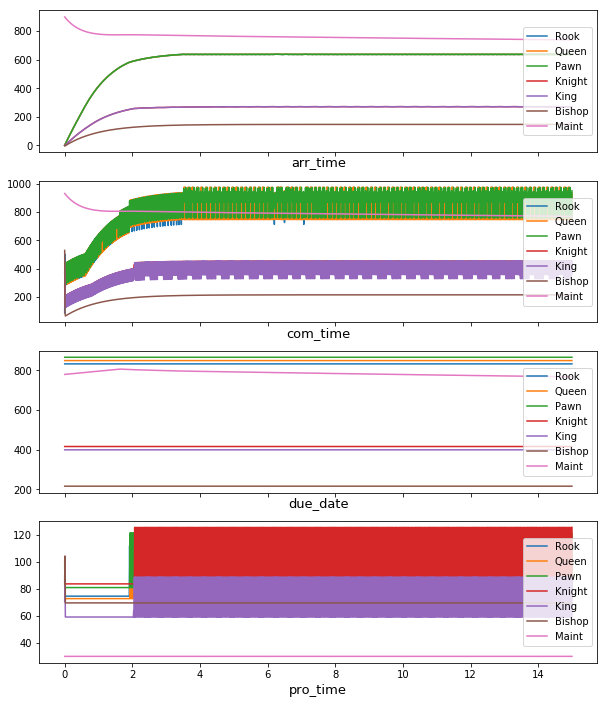

In [162]:
fig, ax = plt.subplots(4, figsize=(10, 12),sharex=True)
x = np.linspace(0,15,iterations+1)
#char = ['g','b:','r--', 'c--']
l = ['Rook', 'Queen', 'Pawn', 'Knight', 'King', 'Bishop','Maint']
for i in range(num_parts+num_components): ax[0].plot(x, save_arr[:,i]/60)
for i in range(num_parts+num_components): ax[1].plot(x, save_cmp[:,i]/60)
for i in range(num_parts+num_components): ax[2].plot(x, save_due_date[:,i]/60)
for i in range(num_parts+num_components): ax[3].plot(x, save_p[:,i]/60)
ax[0].legend(l, loc = 7)
ax[1].legend(l, loc = 7)
ax[2].legend(l,  loc = 7)
ax[3].legend(l,  loc = 7)
ax[0].set_xlabel('arr_time', fontsize = 13)
ax[1].set_xlabel('com_time', fontsize = 13)
ax[2].set_xlabel('due_date', fontsize = 13)
ax[3].set_xlabel('pro_time', fontsize = 13)


(249.46542277413477, 379.42264828267861, 129.95722550854381)

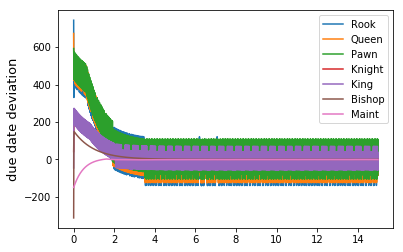

In [163]:
x = np.linspace(0,15,iterations+1)

l = ['Rook', 'Queen', 'Pawn', 'Knight', 'King', 'Bishop','Maint']
for i in range(num_parts+num_components):
    z = (save_due_date[:,i]-save_cmp[:,i])/60
    plt.plot(x, z)
plt.legend(l)
plt.ylabel('due date deviation', fontsize = 13)
ss_z = np.sum(np.abs(save_due_date[-100:,:]-save_cmp[-100:,:]), axis = 1)
np.min(ss_z)/60, np.max(ss_z)/60, (np.max(ss_z)-np.min(ss_z))/60

__Experiment 3__
- Six print parts, Three Machine(Maintenance) Case

In [167]:
#Step 1.1: Initialization: parts information
num_parts = 6                             # number of parts in the system
volume = np.array([26875, 26216, 29169,
                  30152, 21303, 25072])   # volume of parts unit: mm^3
min_e_rate = 4                            # min extrution rate unit: mm^3/sec
max_e_rate = 6                           # max extrution rate unit: mm^3/sec
min_temp = 180                            # min temperature unit: degree C
max_temp = 230                            # max temperature unit: degree C
init_e_rate = np.array([5, 5, 5, 
                        5, 5, 5])         # initial extrution rate unit: mm^3/sec
due_date = np.array([50000, 51000, 52000, 
                       25000, 24000, 13000]) # the due date of parts, unit: sec
arr_time = np.array([0, 0, 0, 
                     0, 0, 0])            # the arrival times, unit: sec

#Step 1.2: Ininitialization: maintenance information
num_components = 3
RUL = np.array([6000, 6000, 6000])
tm = np.array([1800, 1800, 1800])         # the maintenance time, unit: sec
maint_due_date = np.array([46800, 46800, 46800])  # set the maintance initial due dates, unit: sec
maint_arr_time = np.array([54000, 54000, 46800])  # set the maintance action time, unit: sec
iterations = 1500                   # algorithm running iteration
cl=0                                # running iteration index

#Step 2: Generate entities
parts = []
components = []
for i in range(num_parts):
    parts.append(Parts(i, volume[i], init_e_rate[i] ,min_e_rate, max_e_rate, due_date[i], arr_time[i]))
for j in range(num_components):
    components.append(Components(j, tm[j], RUL[j], maint_due_date[j], maint_arr_time[j]))
    #print(components[j].maint_due_date)
    
#Step 4: using preemptive simulation model to simulate the model
while cl<=iterations:
    # arrival time array
    parts_arr = np.array([p.arr_time for p in parts])
    maint_arr = np.array([c.maint_arr_time for c in components])
    total_arr = np.hstack((parts_arr, maint_arr))
    # process time array
    parts_pt = np.array([p.hat_p for p in parts])
    maint_pt = np.array([c.tm for c in components])
    total_pt = np.hstack((parts_pt, maint_pt))
    # motor speed array
    parts_ms = np.array([p.hat_motor_speed for p in parts])
    maint_ms = np.array([0 for c in components])
    total_ms = np.hstack((parts_ms, maint_ms))
    
    # do preemptive queue simulation
    model = MultiMachineCBMModel(num_parts, num_components, total_arr, total_pt, total_ms)
    total_ct = model.get_comp_times()
    parts_ct = total_ct[0:num_parts]
    maint_ct = total_ct[-num_components:]
    maint_load = model.get_machine_loads()
    
    # update parts information
    for i in range(num_parts):
        parts[i].update_comp_time(parts_ct[i])
        parts[i].update_z()
        parts[i].update_e_rate()
        parts[i].update_motor_speed()
        parts[i].update_prod_time()
        parts[i].update_arr_time()
    
    # update components information
    for j in range(num_components):
        components[j].update_comp_time(maint_ct[j])
        components[j].update_delta(maint_load[j])
        components[j].update_due_date()
        components[j].update_z()
        components[j].update_arr_time()
        
    #save datas
    if cl == 0:
        save_arr = total_arr
        save_cmp = total_ct
        save_due_date = np.hstack(([p.d for p in parts],[c.maint_due_date for c in components]))
        save_p = total_pt
    else:
        save_arr = np.vstack((save_arr, total_arr))
        save_cmp = np.vstack((save_cmp, total_ct))
        save_due_date = np.vstack((save_due_date, 
                                   np.hstack(([p.d for p in parts],[c.maint_due_date for c in components]))))
        save_p = np.vstack((save_p, total_pt))
    cl += 1
print(save_arr[-1])
print(save_cmp[-1])
print(save_due_date[-1])
print(save_p[-1])
print(maint_load)

[ 43720.82939797  44830.6593228   42909.26269586  19974.66098283
  20449.49418194   8821.330812    43986.46526461  45266.171345
  46321.9439454 ]
[ 49999.99606464  50999.99265613  52001.51269586  24999.99431616
  23999.99418194  12999.99747867  45786.46526461  47066.171345
  48121.9439454 ]
[ 50000.          51000.          52000.          25000.          24000.
  13000.          45586.18968476  47063.08647822  48093.27856515]
[ 4479.16666667  4369.33333333  7292.25        5025.33333333  3550.5
  4178.66666667  1800.          1800.          1800.        ]
[ 8403.31130556  6034.46486184  6320.31239549]


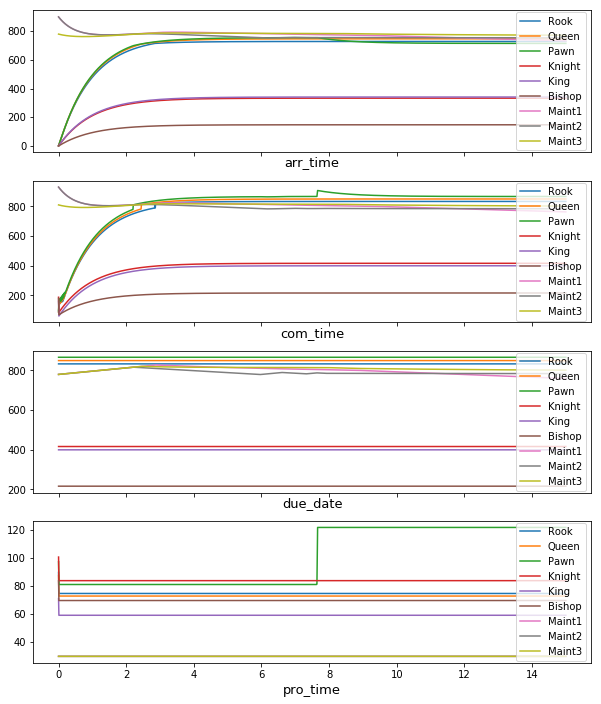

In [170]:
fig, ax = plt.subplots(4, figsize=(10, 12),sharex=True)
x = np.linspace(0,15,iterations+1)
#char = ['g','b:','r--', 'c--']
l = ['Rook', 'Queen', 'Pawn', 'Knight', 'King', 'Bishop','Maint1', 'Maint2', 'Maint3']
for i in range(num_parts+num_components): ax[0].plot(x, save_arr[:,i]/60)
for i in range(num_parts+num_components): ax[1].plot(x, save_cmp[:,i]/60)
for i in range(num_parts+num_components): ax[2].plot(x, save_due_date[:,i]/60)
for i in range(num_parts+num_components): ax[3].plot(x, save_p[:,i]/60)
ax[0].legend(l, loc = 7)
ax[1].legend(l, loc = 7)
ax[2].legend(l,  loc = 7)
ax[3].legend(l,  loc = 7)
ax[0].set_xlabel('arr_time', fontsize = 13)
ax[1].set_xlabel('com_time', fontsize = 13)
ax[2].set_xlabel('due_date', fontsize = 13)
ax[3].set_xlabel('pro_time', fontsize = 13)


(3.8927304198815063, 4.0153278472590195, 0.12259742737751367)

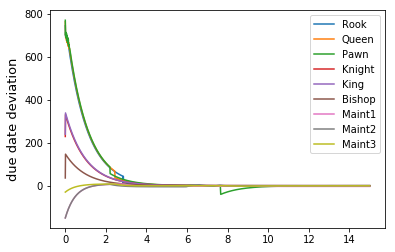

In [172]:
x = np.linspace(0,15,iterations+1)
l = ['Rook', 'Queen', 'Pawn', 'Knight', 'King', 'Bishop','Maint1', 'Maint2', 'Maint3']
for i in range(num_parts+num_components): 
    plt.plot(x, (save_due_date[:,i]-save_cmp[:,i])/60)
plt.legend(l)
plt.ylabel('due date deviation', fontsize = 13)
ss_z = np.sum(np.abs(save_due_date[-100:,:]-save_cmp[-100:,:]), axis = 1)
np.min(ss_z)/60, np.max(ss_z)/60, (np.max(ss_z)-np.min(ss_z))/60